In [44]:
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
import os
import cv2

In [3]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/d4rklucif3r/cat-and-dogs')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jayantghadge
Your Kaggle Key: ··········


100%|██████████| 218M/218M [00:01<00:00, 115MB/s]


In [4]:
train_path='/content/cat-and-dogs/dataset/training_set'
test_path='/content/cat-and-dog/test_set/training_set'

In [25]:
train_ds = keras.preprocessing.image_dataset_from_directory(train_path,validation_split=0.2, subset='training',
                                                            image_size=(128,128),
                                                            batch_size=32,
                                                            seed=0)
val_ds = keras.preprocessing.image_dataset_from_directory(train_path,validation_split=0.2, subset='validation',
                                                           image_size=(128,128),
                                                           batch_size=32,
                                                           seed=0)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


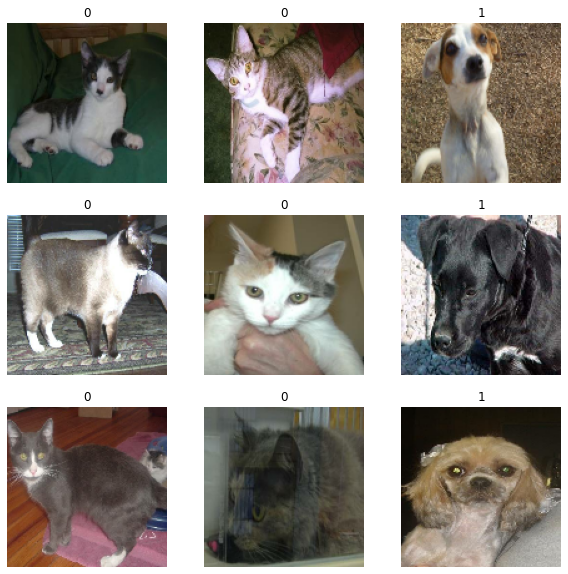

In [26]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

In [27]:
data_aug = keras.Sequential(
    [
        keras.layers.RandomFlip("vertical"),
     keras.layers.RandomRotation(0.5)
    ]
)

In [28]:
train_ds = train_ds.map(
    lambda x,y: (data_aug(x,training=True),y)
)
train_ds = train_ds.map(
    lambda x,y: (x/255,y)
)

In [29]:
train_ds = train_ds.prefetch(64)
val_ds = val_ds.prefetch(64)

In [32]:
def build_model(image_size):
  input = keras.layers.Input(image_size)
  x = keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='same')(input)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

  x = keras.layers.Conv2D(filters=32,kernel_size=(5,5),padding='same')(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

  x = keras.layers.Conv2D(filters=16,kernel_size=(5,5),padding='same')(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

  x = keras.layers.Flatten()(x)
  #x = keras.layers.Dense(256,activation='relu')(x)
  x = keras.layers.Dense(256,activation='relu')(x)
  x = keras.layers.Dropout(0.5)(x)

  output= keras.layers.Dense(1,activation='sigmoid')(x)

  model= keras.Model(inputs=input, outputs=output)
  return model

In [33]:
model = build_model((128,128,3))

In [34]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      4864      
                                                                 
 activation_9 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        51232     
                                                                 
 activation_10 (Activation)  (None, 64, 64, 32)        0         
                                                           

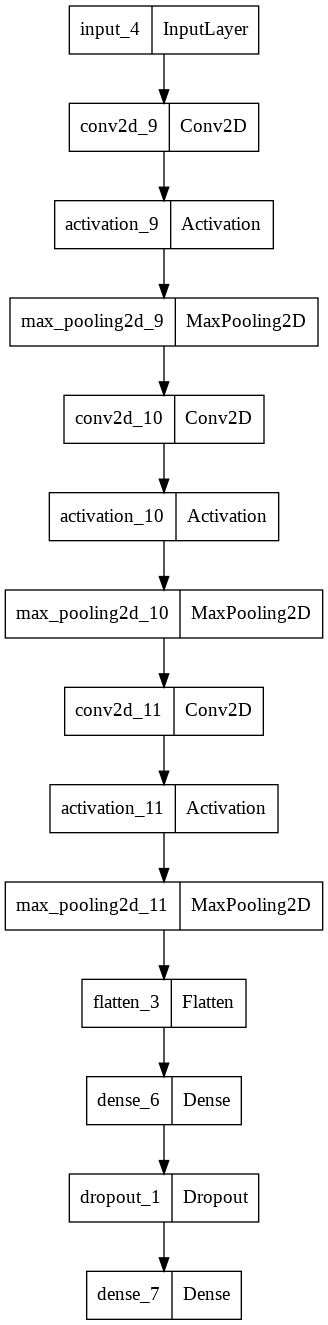

In [35]:
keras.utils.plot_model(model)

In [38]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [39]:
history=model.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
200/200 [==============================] - 20s 95ms/step - loss: 0.7153 - accuracy: 0.5075 - val_loss: 30.7665 - val_accuracy: 0.4988
Epoch 2/20
200/200 [==============================] - 19s 93ms/step - loss: 0.6924 - accuracy: 0.5414 - val_loss: 11.3305 - val_accuracy: 0.5131
Epoch 3/20
200/200 [==============================] - 19s 94ms/step - loss: 0.6869 - accuracy: 0.5748 - val_loss: 46.1805 - val_accuracy: 0.5013
Epoch 4/20
200/200 [==============================] - 20s 96ms/step - loss: 0.6852 - accuracy: 0.5816 - val_loss: 20.0298 - val_accuracy: 0.5806
Epoch 5/20
200/200 [==============================] - 19s 94ms/step - loss: 0.6523 - accuracy: 0.6277 - val_loss: 41.0576 - val_accuracy: 0.5775
Epoch 6/20
200/200 [==============================] - 19s 94ms/step - loss: 0.6504 - accuracy: 0.6272 - val_loss: 40.0593 - val_accuracy: 0.5881
Epoch 7/20
200/200 [==============================] - 24s 118ms/step - loss: 0.6401 - accuracy: 0.6502 - val_loss: 32.7347 - val_a

In [42]:
import sys
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.close()
summarize_diagnostics(history)

Optimizations made :
1. Batch Normalization layers have been added after every convoltion-maxpool block.
2. Dropout layers have been added with dropout rate 0f 0.2
3. The number of layers in the classifier tried : 6 , 4 , 2
4. Optimizers that were tried : ADAM , RMS Prop 

In [41]:
model.save('cat_dog_model.h5')

Chances that its a Dog :  100.0 %


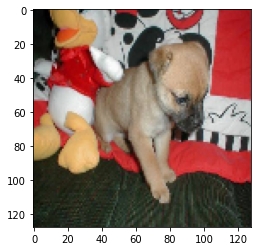

In [62]:
img = cv2.resize(cv2.cvtColor(cv2.imread('/content/cat-and-dogs/dataset/test_set/dogs/dog.4194.jpg'),cv2.COLOR_BGR2RGB),(128,128))
plt.imshow(img)
b=model.predict(np.array([img]))
print('Chances that its a Dog : ',round(b[0][0],3)*100,'%')

Chances that it's a dog:  0.0 %


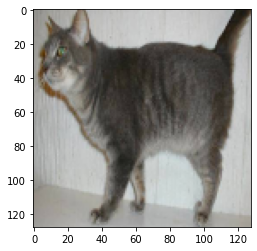

In [61]:
img = cv2.resize(cv2.cvtColor(cv2.imread('/content/cat-and-dogs/dataset/test_set/cats/cat.4194.jpg'),cv2.COLOR_BGR2RGB),(128,128))
plt.imshow(img)
b=model.predict(np.array([img]))
print("Chances that it's a dog: ",round(b[0][0],3)*100,'%')

Chances that its a Dog :  100.0 %


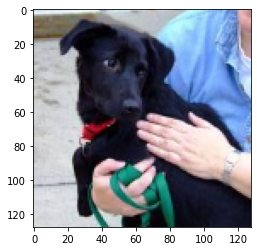

In [63]:
img = cv2.resize(cv2.cvtColor(cv2.imread('/content/cat-and-dogs/dataset/test_set/dogs/dog.4440.jpg'),cv2.COLOR_BGR2RGB),(128,128))
plt.imshow(img)
b=model.predict(np.array([img]))
print('Chances that its a Dog : ',round(b[0][0],3)*100,'%')

Chances that it's a dog:  1.9999999552965164 %


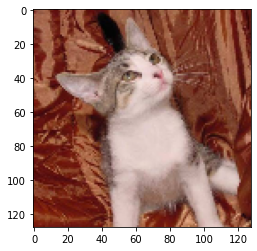

In [64]:
img = cv2.resize(cv2.cvtColor(cv2.imread('/content/cat-and-dogs/dataset/test_set/cats/cat.4450.jpg'),cv2.COLOR_BGR2RGB),(128,128))
plt.imshow(img)
b=model.predict(np.array([img]))
print("Chances that it's a dog: ",round(b[0][0],3)*100,'%')